# VOLUME BUDGET
* **Test dataset**: Reference configuration SPITZ12 ([NEMO 4.0.2](http://forge.ipsl.jussieu.fr/nemo/svn/NEMO/releases/r4.0/r4.0.2)).  
* **Relevant nemo code**: [src/OCE/DYN/sshwzv.F90](http://forge.ipsl.jussieu.fr/nemo/svn/NEMO/releases/r4.0/r4.0.2/src/OCE/DYN/sshwzv.F90).
* **Diagnostics**: The following diagnostics (all averages) are needed to close the budget (see customized `file_def_nemo-oce.xml` and `diawri.F90` below).
    * ssha (custom)
    * sshb (custom)
    * empmr
    * empbmr
    * uoce_e3u
    * voce_e3v
* **Note**: Boundaries (2 outermost grid-points) and initial time-step require special treatment and are cut out.  

## Import modules

In [1]:
import xarray as xr
import os
import xgcm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from collections import OrderedDict
import xml.dom.minidom
import difflib

## Set parameters

In [2]:
# Set paths
ref_conf = "SPITZ12"
working_dir = f"/work/n01/n01/malmans/nemo/cfgs/{ref_conf}/EXP00"
nc_files = f"*_*_*_*_grid_*.nc"
cn_domcfg = "domain_cfg.nc"

# Set constants
rau0 = 1026.0  # volumic mass of reference [kg / m3]
rn_rdt = 720  # ocean time step [s]

# Plotting
figsize_big = (15, 10)
figsize_small = (15, 5)
plt.rcParams.update({"font.size": 15})

## Show XIOS setup

In [3]:
dom = xml.dom.minidom.parse(os.path.join(working_dir, "file_def_nemo-oce.xml"))
print(dom.toxml())

<?xml version="1.0" ?><!-- 
=                                           output files definition                                        =
=                                            Define your own files                                         =
=                                         put the variables you want...                                    =
--><file_definition type="multiple_file" name="@expname@_@freq@_@startdate@_@enddate@" sync_freq="10d" min_digits="4">

        <file_group id="3d" output_freq="3d" output_level="10" enabled=".TRUE.">

                <file id="file1" name_suffix="_grid_T" description="ocean T grid variables" enabled=".TRUE.">
			<field field_ref="ssh" operation="instant" enabled=".TRUE." prec="8" name="sshn_first" freq_op="3d"/>
			<field field_ref="ssh" operation="instant" enabled=".TRUE." prec="8" name="sshn_last"/>
			<field field_ref="ssha" operation="instant" enabled=".TRUE." prec="8" name="ssha_last"/>
			<field field_ref="sshb" operation="instant

### Show diagnostics added

In [4]:
myfile_path = "/".join(working_dir.split("/")[:-1] + ["MY_SRC", "diawri.F90"])
nemofile_path = myfile_path.replace(f"cfgs/{ref_conf}/MY_SRC", "src/OCE/DIA")

text1 = open(myfile_path).readlines()
text2 = open(nemofile_path).readlines()

for line in difflib.unified_diff(text1, text2):
    print(line)

--- 

+++ 

@@ -135,13 +135,9 @@

          CALL iom_put( "e3tdef"  , ( ( e3t_n(:,:,:) - e3t_0(:,:,:) ) / e3t_0(:,:,:) * 100 * tmask(:,:,:) ) ** 2 )

 

       IF( ll_wd ) THEN

-         CALL iom_put( "ssh",  (sshn+ssh_ref)*tmask(:,:,1) )   ! sea surface height (brought back to the reference used for wetting and drying)

-         CALL iom_put( "ssha", (ssha+ssh_ref)*tmask(:,:,1) )   ! sea surface height after (brought back to the reference used for wetting and drying)

-         CALL iom_put( "sshb", (sshb+ssh_ref)*tmask(:,:,1) )   ! sea surface height before (brought back to the reference used for wetting and drying)

+         CALL iom_put( "ssh" , (sshn+ssh_ref)*tmask(:,:,1) )   ! sea surface height (brought back to the reference used for wetting and drying)

       ELSE

-         CALL iom_put( "ssh", sshn )              ! sea surface height

-         CALL iom_put( "ssha", ssha )             ! sea surface height after

-         CALL iom_put( "sshb", sshb )             ! sea sur

## Open domain file

In [5]:
# Open cn_domcfg
ds_grid = xr.open_dataset(
    os.path.join(working_dir, cn_domcfg), drop_variables=["time_counter"]
).squeeze("t")

# Rename dimensions, so variables are associated with the correct axis (center or right axis).
# See Table 3.1 (NEMO book)
coords_dict = OrderedDict(
    # Check uw, vw, and fw first because they have 2 letters
    uw=dict(x="x_r", y="y_c", z="z_l"),
    vw=dict(x="x_c", y="y_r", z="z_l"),
    fw=dict(x="x_r", y="y_r", z="z_l"),
    t=dict(x="x_c", y="y_c", z="z_c"),
    u=dict(x="x_r", y="y_c", z="z_c"),
    v=dict(x="x_c", y="y_r", z="z_c"),
    w=dict(x="x_c", y="y_c", z="z_l"),
    f=dict(x="x_r", y="y_r", z="z_c"),
)

# Variables to treat as t (can't infer from name).
manual_t_vars = [
    "nav_lon",
    "nav_lat",
    "nav_lev",
    "bottom_level",
    "top_level",
    "stiffness",
    "bounds_nav_lon",
    "bounds_nav_lat",
    "area",
]

# Infer variable axes (e.g., check if variable ends with t or contains _t)
for var in ds_grid.variables:
    for coord in coords_dict.keys():
        if (
            var.endswith(coord)
            or f"{coord}_" in var
            or (var in manual_t_vars and coord == "t")
        ):
            # Found corresponding coordinates. Rename (existing) dimensions.
            ds_grid[var] = ds_grid[var].rename(
                {
                    k: v
                    for k, v in coords_dict[coord].items()
                    if k in ds_grid[var].dims
                }
            )
            break

## Function to make output xarray/xgcm compatible

In [6]:
def xcompatible(ds):
    """
    NetCDFs have different dimensions with the same name (e.g., both x_c and x_r are named x).
    This function renames these dimensions, so all variables can be merged in the same dataset.
    It also sets the time_centered dimension for averages and time_instant for snapshots.
    """

    # Rename dimensions
    if "T grid" in ds.attrs["description"]:
        dims2ren = dict(y="y_c", x="x_c", deptht="z_c")
    elif "U grid" in ds.attrs["description"]:
        dims2ren = dict(y="y_c", x="x_r", depthu="z_c")
    elif "V grid" in ds.attrs["description"]:
        dims2ren = dict(y="y_r", x="x_c", depthv="z_c")
    elif "W grid" in ds.attrs["description"]:
        dims2ren = dict(y="y_c", x="x_c", depthw="z_l")
    else:
        raise ValueError("I don't know the grid of this dataset.")
    ds = ds.rename_dims({k: v for k, v in dims2ren.items() if k in ds.dims})

    # Set time centered and instant as dimensions
    for tcoord in ["time_centered", "time_instant"]:
        if tcoord in ds.variables:
            ds[tcoord] = xr.DataArray(
                ds[tcoord].values, dims=tcoord, attrs=ds[tcoord].attrs
            )

    # Set dimension time_centered for averages, time_instant  for snapshots
    for var in ds.variables:
        VAR = ds[var].drop_vars(ds[var].coords)
        if "online_operation" in ds[var].attrs:
            if any(var.endswith(suffix) for suffix in ["_last", "first"]):
                ds[var] = VAR.rename(time_counter="time_centered")
            elif ds[var].attrs["online_operation"] == "average":
                ds[var] = VAR.rename(time_counter="time_centered")
            elif ds[var].attrs["online_operation"] == "instant":
                ds[var] = VAR.rename(time_counter="time_instant")
    return ds

## Open datasets and create grid object

In [7]:
# xarray
ds = xr.open_mfdataset(
    os.path.join(working_dir, nc_files),
    preprocess=xcompatible,
    combine="by_coords",
    drop_variables=manual_t_vars,
    decode_times=True,
)
ds = xr.merge([ds, ds_grid])
print(ds)

# xgcm
grid = xgcm.Grid(
    ds,
    coords={
        "X": {"center": "x_c", "right": "x_r"},
        "Y": {"center": "y_c", "right": "y_r"},
        "T": {"center": "time_centered", "right": "time_instant"},
        "Z": {"center": "z_c", "left": "z_l"},
    },
)

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_centered: 3, time_counter: 3, time_instant: 3, x_c: 117, x_r: 117, y_c: 115, y_r: 115, z_c: 75, z_l: 75)
Coordinates:
  * time_centered         (time_centered) object 2002-01-02 12:00:00 ... 2002-01-08 12:00:00
    depthu                (z_c) float32 0.50576 1.5558553 ... 5902.0576
  * time_counter          (time_counter) object 2002-01-02 12:00:00 ... 2002-01-08 12:00:00
    depthv                (z_c) float32 0.50576 1.5558553 ... 5902.0576
    depthw                (z_l) float32 0.0 1.0239066 ... 5596.249 5800.0
  * time_instant          (time_instant) object 2002-01-04 00:00:00 ... 2002-01-10 00:00:00
Dimensions without coordinates: axis_nbounds, x_c, x_r, y_c, y_r, z_c, z_l
Data variables:
    depthu_bounds         (z_c, axis_nbounds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(3, 2), meta=np.ndarray>
    time_counter_boun

## Volume budget
### $\frac{\overline{\mathrm{ssha}}-\overline{\mathrm{sshb}}}{2 \mathrm{rn\_rdt}}=\frac{1}{e_1 e_2}\displaystyle\sum_{k}\left\{\delta_i\left[e_{2u}\overline{e_{3u}u}\right]+\delta_j\left[e_{1v}\overline{e_{3v}v}\right]\right\}-\frac{\overline{\mathrm{empmr}}+\overline{\mathrm{empbmr}}}{2\rho_w}$

In [8]:
# Left-Hand Side
dssh_dt = (ds.ssha - ds.sshb) / (2 * rn_rdt)
LHS = dssh_dt.assign_coords(
    {f"g{coord}t": ds[f"g{coord}t"] for coord in ["lam", "phi"]}
)
LHS = LHS.rename("LHS")

# Right-Hand Side
transpU = ds.uoce_e3u * ds.e2u
transpV = ds.voce_e3v * ds.e1v
area = ds.e1t * ds.e2t
hor_div = grid.diff(transpU, "X") + grid.diff(transpV, "Y")
forcing = (ds.empbmr + ds.empmr) / (2 * rau0)
RHS = -hor_div.sum("z_c") / area - forcing
RHS = RHS.rename("RHS")

## Compute errors

In [9]:
# Concatenate
bdgt = xr.concat(
    [LHS.expand_dims(side=["Lefthand"]), RHS.expand_dims(side=["Righthand"])],
    "side",
)
bdgt.attrs["units"] = "m/s"
absE = np.abs(bdgt.diff("side")).squeeze()
absE.attrs["units"] = "m/s"
relE = absE * 100 / np.abs(bdgt.sel(side="Lefthand"))
relE.attrs["units"] = "%"

# One dataset
bdgt_ds = xr.Dataset(
    {"SSH tendency": bdgt, "Absolute error": absE, "Relative error": relE}
)

# Exclude boundaries and first time
slices = dict(x_c=slice(2, -2), y_c=slice(2, -2), time_centered=slice(1, None))
bdgt_ds = bdgt_ds.isel(**slices)

# Show dataset
print(bdgt_ds)

<xarray.Dataset>
Dimensions:         (side: 2, time_centered: 2, x_c: 113, y_c: 111)
Coordinates:
    gphit           (y_c, x_c) float64 75.62 75.6 75.58 ... 76.84 76.81 76.78
    glamt           (y_c, x_c) float64 7.166 7.31 7.455 ... 33.74 33.84 33.95
  * time_centered   (time_centered) object 2002-01-05 12:00:00 2002-01-08 12:00:00
  * side            (side) object 'Lefthand' 'Righthand'
Dimensions without coordinates: x_c, y_c
Data variables:
    SSH tendency    (side, time_centered, y_c, x_c) float64 dask.array<chunksize=(1, 2, 111, 113), meta=np.ndarray>
    Absolute error  (time_centered, y_c, x_c) float64 dask.array<chunksize=(2, 111, 113), meta=np.ndarray>
    Relative error  (time_centered, y_c, x_c) float64 dask.array<chunksize=(2, 111, 113), meta=np.ndarray>


## Maps

/work/n01/n01/malmans/anaconda3/envs/xarray/lib/python3.8/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/work/n01/n01/malmans/anaconda3/envs/xarray/lib/python3.8/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/work/n01/n01/malmans/anaconda3/envs/xarray/lib/python3.8/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


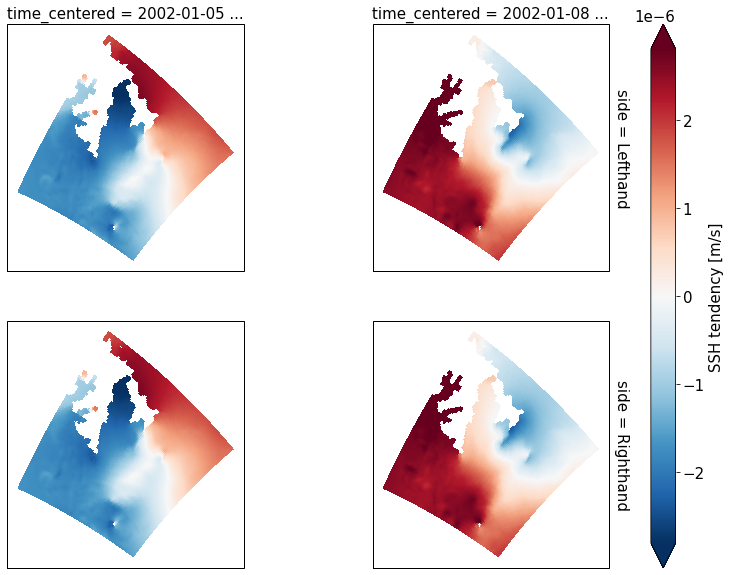

/work/n01/n01/malmans/anaconda3/envs/xarray/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


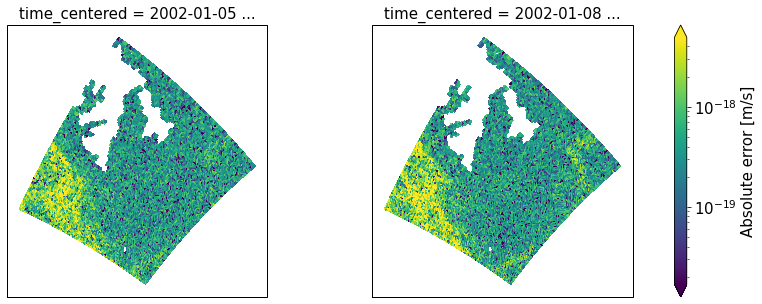

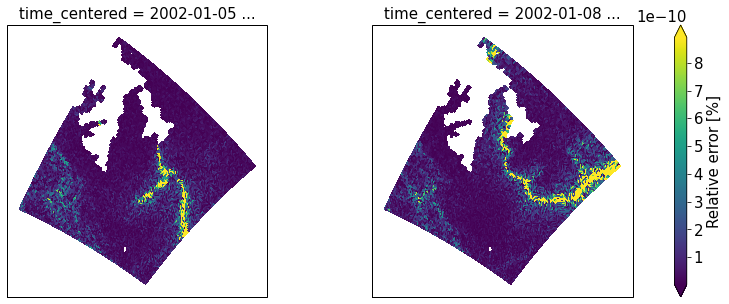

In [10]:
# Plot kwargs
plot_kwargs = dict(
    col="time_centered",
    robust=True,
    transform=ccrs.PlateCarree(),
    x="glamt",
    y="gphit",
    subplot_kws={"projection": ccrs.Mercator()},
)

# Plot RHS and LHS
p = bdgt_ds["SSH tendency"].plot(
    row="side", figsize=figsize_big, **plot_kwargs,
)

# Plot Absolute Error
p = bdgt_ds["Absolute error"].plot(
    norm=colors.LogNorm(), figsize=figsize_small, **plot_kwargs,
)

# Plot Relative
p = bdgt_ds["Relative error"].plot(figsize=figsize_small, **plot_kwargs)

## Magnitude of different sources of error:
### 1. SSH tendency: $\frac{\overline{\mathrm{ssha}}-\overline{\mathrm{sshb}}}{2 \mathrm{rn\_rdt}}\approx \frac{\Delta\mathrm{ssh}}{\Delta\mathrm{time\_instant}}$
### 2. Asselin filter: $\frac{\overline{\mathrm{ssha}}-\overline{\mathrm{sshb}}}{2 \mathrm{rn\_rdt}}\approx \frac{(\mathrm{ssha}^{last}-\mathrm{sshb}^{first})+(\mathrm{sshn}^{last}-\mathrm{sshn}^{first})}{2\Delta\mathrm{time\_instant}}$
### 3. Forcing: $\frac{\overline{\mathrm{empmr}}+\overline{\mathrm{empbmr}}}{2\rho_w} \approx \frac{\overline{\mathrm{empmr}}}{\rho_w}$

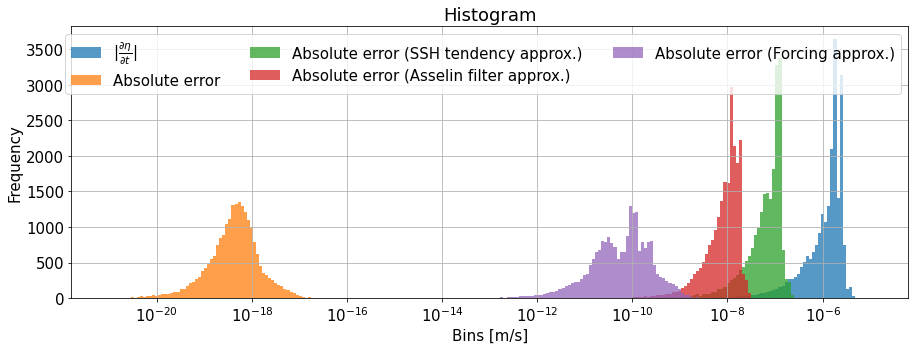

In [11]:
fig, ax = plt.subplots(1, 1, figsize=figsize_small)
plot_kwargs = dict(bins=np.logspace(-21, -5, 250), alpha=0.75, ax=ax)

DT = grid.diff(ds["time_instant"], "T") / np.timedelta64(1, "s")
for i in range(5):
    # Define fields to plot
    if i == 0:
        label = r"$|\frac{\partial \eta}{\partial t}|$"
        da = RHS
    elif i == 1:
        label = "Absolute error"
        da = LHS
    elif i == 2:
        label = "Absolute error (SSH tendency approx.)"
        da = grid.diff(ds.ssh, "T") / DT
    elif i == 3:
        label = "Absolute error (Asselin filter approx.)"
        da = (
            (ds.ssha_last - ds.sshb_first) + (ds.sshn_last - ds.sshn_first)
        ) / (2 * DT)
    elif i == 4:
        label = "Absolute error (Forcing approx.)"
        da = -hor_div.sum("z_c") / area - ds.empmr / rau0

    # Compute error
    if i != 0:
        da = da - RHS

    # Remove boundaries and initial T
    da = da.isel(**slices)

    # Plot
    np.abs(da).plot.hist(
        **plot_kwargs, label=label,
    )

# Labelling
ax.set_xscale("log")
ax.set_xlabel("Bins [m/s]")
ax.set_ylabel("Frequency")
plt.grid()
_ = plt.legend(ncol=3)